In [1]:
# ============================================================
# CELL 1: IMPORTS
# ============================================================

# ============================================================
# CORE NUMERICAL & DATA HANDLING
# ============================================================
import numpy as np
import pandas as pd

# ============================================================
# VISUALIZATION
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# STATISTICAL TESTING
# ============================================================
from scipy import stats

# ============================================================
# SKLEARN: MODEL SELECTION & VALIDATION
# ============================================================
from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split
)

# ============================================================
# SKLEARN: MODELS
# ============================================================
from sklearn.ensemble import RandomForestClassifier

# ============================================================
# SKLEARN: METRICS & FEATURE IMPORTANCE
# ============================================================
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    mutual_info_score
)
from sklearn.inspection import permutation_importance

# ============================================================
# GRADIENT BOOSTING
# ============================================================
import xgboost as xgb

# ============================================================
# RULE / ILP / STRUCTURAL UTILITIES
# ============================================================
import itertools
from collections import defaultdict
from dataclasses import dataclass
from typing import List, Dict, Tuple, Set

# ============================================================
# WARNINGS CONTROL
# ============================================================
import warnings
warnings.filterwarnings("ignore")


In [2]:
# ============================================================
# CELL 2: LOAD & INSPECT DATA
# ============================================================

# Load dataset
path = "/content/sample_data/bank-full.csv"
df = pd.read_csv(path, sep=";")

print(f"Shape: {df.shape}")
df.head()


Shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# ============================================================
# CELL 4: EXAMINE CATAGORICAL COLUMNS
# ============================================================
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("📌 CATEGORICAL COLUMNS\n" + "-"*60)
categorical_cols

for col in categorical_cols:
    print(f"\n🔎 Column: {col}")
    print("-" * 40)

    values = (
        df[col]
        .astype(str)
        .value_counts(dropna=False)
        .sort_index()
    )

    print(values)


📌 CATEGORICAL COLUMNS
------------------------------------------------------------

🔎 Column: job
----------------------------------------
job
admin.           5171
blue-collar      9732
entrepreneur     1487
housemaid        1240
management       9458
retired          2264
self-employed    1579
services         4154
student           938
technician       7597
unemployed       1303
unknown           288
Name: count, dtype: int64

🔎 Column: marital
----------------------------------------
marital
divorced     5207
married     27214
single      12790
Name: count, dtype: int64

🔎 Column: education
----------------------------------------
education
primary       6851
secondary    23202
tertiary     13301
unknown       1857
Name: count, dtype: int64

🔎 Column: default
----------------------------------------
default
no     44396
yes      815
Name: count, dtype: int64

🔎 Column: housing
----------------------------------------
housing
no     20081
yes    25130
Name: count, dtype: int64

🔎 Co

In [4]:
# ============================================================
# CELL 5: PREPROCESSING
# ============================================================

print("\n" + "="*80)
print("🔧 CLEAN PREPROCESSING FROM SCRATCH (NUMERIC-ONLY)")
print("="*80)

print(f"\nOriginal data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# --------------------------------------------------
# 1. CREATE CLEAN df_proc FRAME
# --------------------------------------------------
print("\n" + "="*40)
print("1. CREATING CLEAN df_proc")
print("="*40)

df_proc = df.copy()

print(f"\nInitial shape: {df_proc.shape}")
print(f"Columns: {list(df_proc.columns)}")

# --------------------------------------------------
# 1.1 Target encoding (STRICT)
# --------------------------------------------------
print(f"\n🔍 Target column 'y' before conversion:")
print(df_proc['y'].value_counts())

df_proc['y'] = df_proc['y'].map({'yes': 1, 'no': 0})
assert df_proc['y'].notna().all(), "❌ Unexpected values in target y"
df_proc['y'] = df_proc['y'].astype('int8')

print(f"\n✅ Target 'y' converted:")
print(df_proc['y'].value_counts())

# --------------------------------------------------
# 1.2 Binary categorical encoding
# --------------------------------------------------
binary_cols = ['default', 'housing', 'loan']
binary_map = {'no': 0, 'yes': 1}

print(f"\n🔍 Binary columns before conversion:")
for col in binary_cols:
    print(f"{col}:\n{df_proc[col].value_counts()}")

for col in binary_cols:
    df_proc[col] = df_proc[col].map(binary_map)
    assert df_proc[col].notna().all(), f"❌ Unexpected values in {col}"
    df_proc[col] = df_proc[col].astype('int8')

print(f"\n✅ Binary columns converted:")
for col in binary_cols:
    print(f"{col}: {df_proc[col].unique()}")

# --------------------------------------------------
# 1.3 Month → ordinal (DROP RAW MONTH)
# --------------------------------------------------
print(f"\n🔍 Month column before conversion:")
print(df_proc['month'].value_counts().sort_index())

month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

df_proc['month_ordinal'] = df_proc['month'].map(month_map)
assert df_proc['month_ordinal'].notna().all(), "❌ Unexpected month values"
df_proc['month_ordinal'] = df_proc['month_ordinal'].astype('int8')

# DROP raw month (no objects allowed)
df_proc.drop(columns=['month'], inplace=True)

print(f"\n✅ Month converted to ordinal and raw month dropped")

# --------------------------------------------------
# 1.4 POUTCOME - EXPLICIT MAPPING
# --------------------------------------------------
print(f"\n🔍 poutcome column before conversion:")
print(df_proc['poutcome'].value_counts())

poutcome_map = {
    'unknown': 0,
    'failure': 1,
    'other': 2,
    'success': 3
}

df_proc['poutcome'] = df_proc['poutcome'].map(poutcome_map)
assert df_proc['poutcome'].notna().all(), "❌ Unexpected poutcome values"
df_proc['poutcome'] = df_proc['poutcome'].astype('int8')

print(f"\n✅ poutcome converted:")
print(df_proc['poutcome'].value_counts())

# --------------------------------------------------
# 1.5 CONTACT - ORDINAL MAPPING (NOT BINARY)
# --------------------------------------------------
print(f"\n🔍 contact column before conversion:")
print(df_proc['contact'].value_counts())

# Map contact as ORDINAL: cellular=0, telephone=1, unknown=2
contact_map = {
    'cellular': 0,
    'telephone': 1,
    'unknown': 2
}

df_proc['contact'] = df_proc['contact'].map(contact_map)
assert df_proc['contact'].notna().all(), "❌ Unexpected contact values"
df_proc['contact'] = df_proc['contact'].astype('int8')

print(f"\n✅ contact converted to ordinal (0=cellular, 1=telephone, 2=unknown):")
print(df_proc['contact'].value_counts().sort_index())

# --------------------------------------------------
# 1.6 Ordinal / Label encoding REMAINING categoricals
# --------------------------------------------------
categorical_cols = df_proc.select_dtypes(include=['object']).columns.tolist()

print(f"\n🔍 Ordinal-encoding remaining categoricals:")
print(categorical_cols)

for col in categorical_cols:
    df_proc[col] = df_proc[col].astype('category').cat.codes
    df_proc[col] = df_proc[col].astype('int16')

# --------------------------------------------------
# 1.7 HARD TYPE GUARANTEE
# --------------------------------------------------
non_numeric = df_proc.select_dtypes(exclude=['number']).columns.tolist()
assert len(non_numeric) == 0, f"❌ NON-NUMERIC COLUMNS REMAIN: {non_numeric}"

print("\n✅ ALL COLUMNS ARE NUMERIC")

# --------------------------------------------------
# 1.8 Sanity checks
# --------------------------------------------------
print(f"\n📊 Data types in df_proc:")
for dtype in df_proc.dtypes.unique():
    cols = df_proc.columns[df_proc.dtypes == dtype].tolist()
    print(f"{dtype}: {cols}")

print(f"\n🔍 Checking for null values:")
assert df_proc.isnull().sum().sum() == 0, "❌ Nulls detected"
print("✅ No null values")

print(f"\n🔍 Checking for duplicates:")
dup_count = df_proc.duplicated().sum()
print(f"Exact duplicate rows: {dup_count} ({dup_count/len(df_proc)*100:.2f}%)")

# --------------------------------------------------
# 1.9 Final confirmation
# --------------------------------------------------
print(f"\n✅ df_proc created successfully!")
print(f"Shape: {df_proc.shape}")
print(f"Memory usage: {df_proc.memory_usage().sum() / 1024**2:.2f} MB")


🔧 CLEAN PREPROCESSING FROM SCRATCH (NUMERIC-ONLY)

Original data shape: (45211, 17)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

1. CREATING CLEAN df_proc

Initial shape: (45211, 17)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

🔍 Target column 'y' before conversion:
y
no     39922
yes     5289
Name: count, dtype: int64

✅ Target 'y' converted:
y
0    39922
1     5289
Name: count, dtype: int64

🔍 Binary columns before conversion:
default:
default
no     44396
yes      815
Name: count, dtype: int64
housing:
housing
yes    25130
no     20081
Name: count, dtype: int64
loan:
loan
no     37967
yes     7244
Name: count, dtype: int64

✅ Binary columns converted:
default: [0 1]
housing: [1 0]
loan: [0 1]

🔍 Month column before con


📊 ROBUST OUTLIER ANALYSIS (IQR / MEDIAN-BASED)

🔍 Inspecting 4 continuous features:
['duration', 'balance', 'campaign', 'previous']

📋 Robust distribution summary:


,feature,median,IQR,Q1,Q3,P95,P99,max
0,duration,180.0,216.0,103.0,319.0,751.0,1269.0,4918
1,balance,448.0,1356.0,72.0,1428.0,5768.0,13164.9,102127
2,campaign,2.0,2.0,1.0,3.0,8.0,16.0,63
3,previous,0.0,0.0,0.0,0.0,3.0,8.9,275



📦 Boxen plots (better than boxplots for heavy tails)


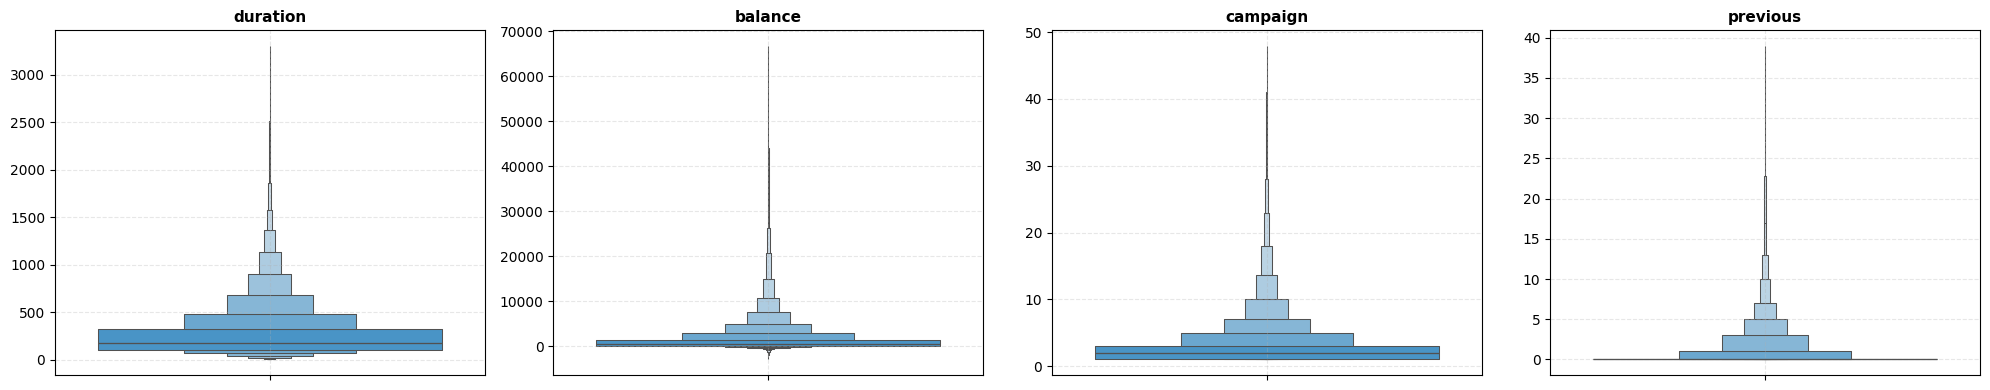


📈 Log-scale histograms (shape diagnostics only)


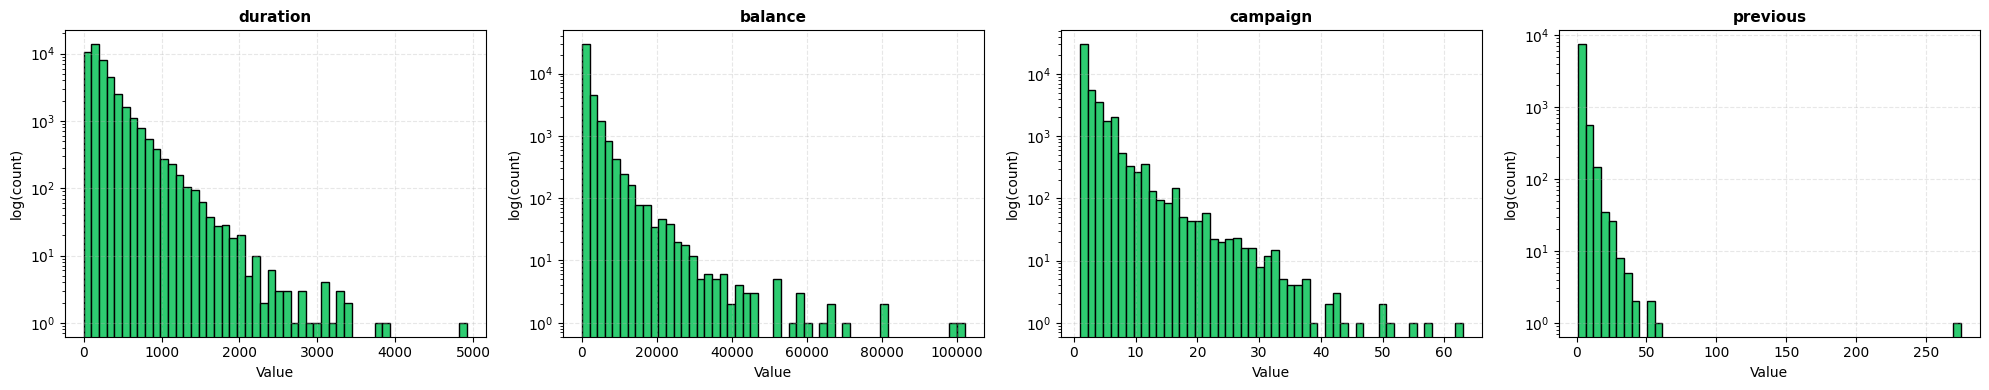


🚨 Extreme-tail flags (for decision-making, not trimming yet)
                duration: >P99 =  1.00% of rows
                 balance: >P99 =  1.00% of rows
                campaign: >P99 =  1.00% of rows
                previous: >P99 =  1.00% of rows


In [5]:
# ============================================================
# CELL 6: ROBUST OUTLIER ANALYSIS
# ============================================================

print("\n" + "="*80)
print("📊 ROBUST OUTLIER ANALYSIS (IQR / MEDIAN-BASED)")
print("="*80)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --------------------------------------------------
# 1. Select CONTINUOUS / RISKY FEATURES ONLY
# --------------------------------------------------
# These are the ones that typically break rule coverage
outlier_features = [
    "duration",
    "balance",
    "campaign",
    "previous",
]

# Add ratio features if already created later in pipeline
optional_ratio_feats = [
    "duration_per_campaign",
    "previous_per_campaign"
]

for f in optional_ratio_feats:
    if f in df_proc.columns:
        outlier_features.append(f)

print(f"\n🔍 Inspecting {len(outlier_features)} continuous features:")
print(outlier_features)

# --------------------------------------------------
# 2. SUMMARY STATS (ROBUST)
# --------------------------------------------------
summary = []

for col in outlier_features:
    s = df_proc[col]
    q1, q2, q3 = s.quantile([0.25, 0.50, 0.75])
    iqr = q3 - q1
    p95 = s.quantile(0.95)
    p99 = s.quantile(0.99)

    summary.append({
        "feature": col,
        "median": q2,
        "IQR": iqr,
        "Q1": q1,
        "Q3": q3,
        "P95": p95,
        "P99": p99,
        "max": s.max()
    })

summary_df = pd.DataFrame(summary)
print("\n📋 Robust distribution summary:")
display(summary_df)

# --------------------------------------------------
# 3. BOXEN PLOTS (ROBUST TO EXTREMES)
# --------------------------------------------------
print("\n📦 Boxen plots (better than boxplots for heavy tails)")

n = len(outlier_features)
fig, axes = plt.subplots(1, n, figsize=(5*n, 4), sharey=False)

if n == 1:
    axes = [axes]

for ax, col in zip(axes, outlier_features):
    sns.boxenplot(
        y=df_proc[col],
        ax=ax,
        color="#3498db",
        showfliers=False
    )
    ax.set_title(col, fontsize=11, fontweight="bold")
    ax.set_ylabel("")
    ax.grid(alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 4. LOG-SCALE HISTOGRAMS (SHAPE INSPECTION)
# --------------------------------------------------
print("\n📈 Log-scale histograms (shape diagnostics only)")

fig, axes = plt.subplots(1, n, figsize=(5*n, 4))

if n == 1:
    axes = [axes]

for ax, col in zip(axes, outlier_features):
    vals = df_proc[col].values
    vals = vals[vals > 0]  # log-safe

    ax.hist(vals, bins=50, log=True, color="#2ecc71", edgecolor="black")
    ax.set_title(col, fontsize=11, fontweight="bold")
    ax.set_xlabel("Value")
    ax.set_ylabel("log(count)")
    ax.grid(alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 5. RULE-RELEVANT OUTLIER FLAGS (NO MUTATION)
# --------------------------------------------------
print("\n🚨 Extreme-tail flags (for decision-making, not trimming yet)")

for col in outlier_features:
    p99 = df_proc[col].quantile(0.99)
    pct = (df_proc[col] > p99).mean() * 100
    print(f"{col:>24}: >P99 = {pct:5.2f}% of rows")


In [6]:
"""
IMPORTANT NOTE ON DATA DISTRIBUTION & OUTLIERS:

We deliberately do NOT scale or alter the natural distributions of the data at this stage.
This includes not removing outliers, not applying normalization, and not transforming variables.

RATIONALE:
1. The observed skewness and extreme values represent real-world customer behavior where
   outliers often encode meaningful business signals rather than noise.

2. Overlapping spikes and distribution discontinuities may reflect:
   - Behavioral threshold effects (e.g., call duration regimes)
   - Temporal or seasonal campaign dynamics
   - Distinct customer segments with non-linear response patterns

3. Our feature engineering strategy (state-based binning and thresholds) is designed to
   capture these effects explicitly while preserving semantic interpretability.

4. The GLASS-BRW framework relies on discovering natural decision boundaries from data,
   rather than imposing artificial smoothness through scaling or normalization.

MODEL-SPECIFIC NOTE:
This choice is intentional for rule-based, threshold-driven models.
Scaling and outlier handling may be revisited for distance-based or linear models,
but are avoided here to preserve interpretability and behavioral signal fidelity.

NEXT STEPS:
- Evaluate whether specific extreme values degrade rule stability
- Apply targeted transformations only if they improve interpretability or robustness
- Continue prioritizing temporal and behavioral signal discovery over distribution smoothing

This approach reflects business reality, where extreme values often identify the most
valuable, risky, or responsive customer segments.
"""

'\nIMPORTANT NOTE ON DATA DISTRIBUTION & OUTLIERS:\n\nWe deliberately do NOT scale or alter the natural distributions of the data at this stage.\nThis includes not removing outliers, not applying normalization, and not transforming variables.\n\nRATIONALE:\n1. The observed skewness and extreme values represent real-world customer behavior where\n   outliers often encode meaningful business signals rather than noise.\n\n2. Overlapping spikes and distribution discontinuities may reflect:\n   - Behavioral threshold effects (e.g., call duration regimes)\n   - Temporal or seasonal campaign dynamics\n   - Distinct customer segments with non-linear response patterns\n\n3. Our feature engineering strategy (state-based binning and thresholds) is designed to\n   capture these effects explicitly while preserving semantic interpretability.\n\n4. The GLASS-BRW framework relies on discovering natural decision boundaries from data,\n   rather than imposing artificial smoothness through scaling or nor

💾 CELL 9: MODEL PERSISTENCE & PREPARATION FOR ENSEMBLE

🔍 USING df_proc TO PREPARE DATA
--------------------------------------------------
df_proc shape: (45211, 17)
df_proc columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y', 'month_ordinal']

Features (X) shape: (45211, 16)
Target (y) shape: (45211,)
Target distribution:
y
0    39922
1     5289
Name: count, dtype: int64
Target proportion: 0.117 (1 = 'yes', 0 = 'no')

✓ Train/Test Split:
  X_train: (36168, 16)
  y_train: (36168,) (positives: 4231 = 0.117)
  X_test: (9043, 16)
  y_test: (9043,) (positives: 1058 = 0.117)

✓ Data scaled using StandardScaler

🤖 TRAINING LOGISTIC REGRESSION MODEL
--------------------------------------------------
Training model...

✅ Model trained!

Performance metrics on test set:
  Accuracy: 0.8236
  Precision: 0.3792
  Recall: 0.7968
  F1-Score: 0.5139
  ROC-AUC: 0.8886

Baseline accuracy 

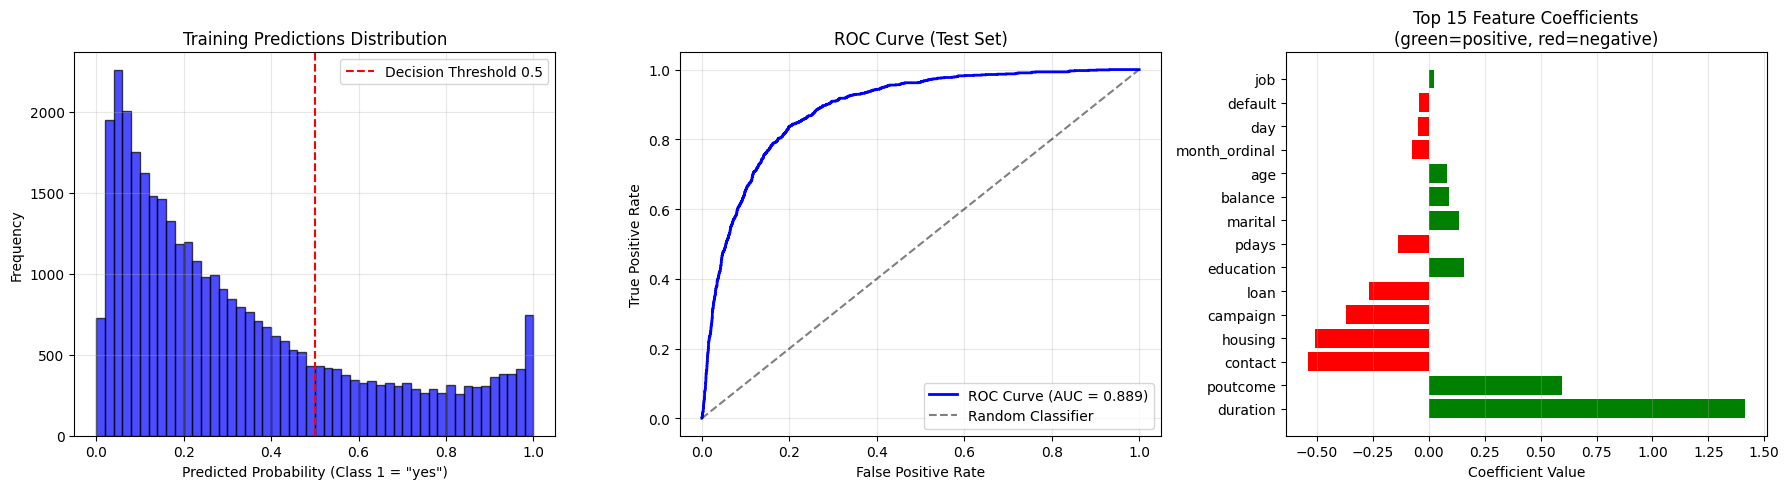


🔍 7. ENSEMBLE COMPATIBILITY CHECK
--------------------------------------------------

First 10 predictions for ensemble:
 logistic_regression_prob  logistic_regression_class  actual_class
                 0.161847                          0             0
                 0.985345                          1             1
                 0.999068                          1             1
                 0.048625                          0             0
                 0.099024                          0             0
                 0.987321                          1             0
                 0.096382                          0             0
                 0.279254                          0             0
                 0.517287                          1             0
                 0.417929                          0             0

📊 Prediction Statistics:
Mean probability: 0.3306
Std probability: 0.2785
Min probability: 0.0000
Max probability: 1.0000
Median probability

In [13]:
# ============================================================
# CELL 9: MODEL PERSISTENCE & PREPARATION FOR ENSEMBLE
# ============================================================
print("=" * 80)
print("💾 CELL 9: MODEL PERSISTENCE & PREPARATION FOR ENSEMBLE")
print("=" * 80)

import pickle
import joblib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score

# --------------------------------------------------
# 0. SETUP - PREPARE DATA FROM df_proc
# --------------------------------------------------
print("\n🔍 USING df_proc TO PREPARE DATA")
print("-" * 50)

print(f"df_proc shape: {df_proc.shape}")
print(f"df_proc columns: {list(df_proc.columns)}")

# Target column is 'y' (0 = no, 1 = yes)
X = df_proc.drop(columns=['y'])  # All columns except 'y'
y = df_proc['y']                 # Target column is 'y'

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Target proportion: {y.mean():.3f} (1 = 'yes', 0 = 'no')")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Train/Test Split:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape} (positives: {y_train.sum()} = {y_train.mean():.3f})")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape} (positives: {y_test.sum()} = {y_test.mean():.3f})")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Data scaled using StandardScaler")

# --------------------------------------------------
# 1. TRAIN LOGISTIC REGRESSION MODEL
# --------------------------------------------------
print("\n🤖 TRAINING LOGISTIC REGRESSION MODEL")
print("-" * 50)

# Create and train the model - using class_weight='balanced' since it's imbalanced
lr_model = LogisticRegression(
    C=1.0,
    penalty='l2',
    random_state=42,
    max_iter=1000,
    class_weight='balanced',  # Important for imbalanced data
    solver='liblinear'        # Good for binary classification
)

print("Training model...")
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1 ('yes')

# Calculate metrics - specify average='binary' for binary classification
metrics_tuned = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='binary'),
    'Recall': recall_score(y_test, y_pred, average='binary'),
    'F1-Score': f1_score(y_test, y_pred, average='binary'),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

print("\n✅ Model trained!")
print("\nPerformance metrics on test set:")
for metric, value in metrics_tuned.items():
    print(f"  {metric}: {value:.4f}")

# Show baseline accuracy (always predicting majority class)
baseline_accuracy = max(y_test.mean(), 1 - y_test.mean())
print(f"\nBaseline accuracy (predicting majority class): {baseline_accuracy:.4f}")
print(f"Model improvement: {metrics_tuned['Accuracy'] - baseline_accuracy:+.4f}")

# --------------------------------------------------
# 2. CREATE ENSEMBLE-READY MODEL OBJECT
# --------------------------------------------------
print("\n🔧 2. CREATING ENSEMBLE-READY MODEL OBJECT")
print("-" * 50)

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("Top 10 most important features (by absolute coefficient):")
print(feature_importance[['Feature', 'Coefficient']].head(10))

# Create ensemble dictionary
lr_ensemble_dict = {
    'model': lr_model,
    'model_name': 'logistic_regression_model',
    'scaler': scaler,
    'feature_names': X.columns.tolist(),
    'training_data_shape': X_train.shape,
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'hyperparameters': {
        'C': 1.0,
        'penalty': 'l2',
        'class_weight': 'balanced',
        'solver': 'liblinear',
        'max_iter': 1000,
        'random_state': 42
    },
    'performance_metrics': metrics_tuned,
    'cv_score': None,  # Not using CV in this example
    'feature_importance': feature_importance.to_dict()
}

# Get training predictions for ensemble stacking
print("\n📊 Generating training predictions for meta-ensemble...")
lr_X_train = lr_model.predict_proba(X_train_scaled)[:, 1]  # Probabilities for class 1
lr_X_test = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"Shape of lr_X_train (probabilities): {lr_X_train.shape}")
print(f"Range: [{lr_X_train.min():.4f}, {lr_X_train.max():.4f}]")
print(f"Mean prediction: {lr_X_train.mean():.4f}")
print(f"Std prediction: {lr_X_train.std():.4f}")

# Add predictions to ensemble dictionary
lr_ensemble_dict['train_predictions'] = lr_X_train
lr_ensemble_dict['test_predictions'] = lr_X_test
lr_ensemble_dict['train_labels'] = y_train.values
lr_ensemble_dict['test_labels'] = y_test.values
lr_ensemble_dict['train_features_shape'] = X_train_scaled.shape

print("\n✅ Ensemble dictionary created with keys:")
for key in lr_ensemble_dict.keys():
    print(f"  - {key}")

# --------------------------------------------------
# 3. SAVE MODEL AND ENSEMBLE DICTIONARY
# --------------------------------------------------
print("\n💾 3. SAVING MODEL TO DISK")
print("-" * 50)

# Define file paths
base_path = "./models"
os.makedirs(base_path, exist_ok=True)

# Create timestamp for filenames
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f"{base_path}/logistic_regression_model_{timestamp}.pkl"
ensemble_filename = f"{base_path}/lr_ensemble_dict_{timestamp}.pkl"
joblib_filename = f"{base_path}/lr_ensemble_joblib_{timestamp}.joblib"

# Save using pickle
with open(model_filename, 'wb') as f:
    pickle.dump(lr_model, f)
print(f"✅ Model saved to: {model_filename}")

with open(ensemble_filename, 'wb') as f:
    pickle.dump(lr_ensemble_dict, f)
print(f"✅ Ensemble dictionary saved to: {ensemble_filename}")

# Save using joblib (better for large numpy arrays)
joblib.dump(lr_ensemble_dict, joblib_filename)
print(f"✅ Ensemble dictionary saved (joblib) to: {joblib_filename}")

# --------------------------------------------------
# 4. VERIFY SAVED MODEL
# --------------------------------------------------
print("\n🔍 4. VERIFYING SAVED MODEL")
print("-" * 50)

# Load the model back
with open(model_filename, 'rb') as f:
    loaded_model = pickle.load(f)

# Test the loaded model
loaded_predictions = loaded_model.predict(X_test_scaled)
loaded_accuracy = accuracy_score(y_test, loaded_predictions)

print(f"Original model accuracy: {metrics_tuned['Accuracy']:.4f}")
print(f"Loaded model accuracy: {loaded_accuracy:.4f}")
print(f"✓ Predictions match: {np.array_equal(loaded_predictions, y_pred)}")

# --------------------------------------------------
# 5. CREATE SUMMARY REPORT
# --------------------------------------------------
print("\n📋 5. MODEL SUMMARY REPORT")
print("-" * 50)

# Create summary
summary_report = f"""
{'='*60}
LOGISTIC REGRESSION MODEL SUMMARY - BANK MARKETING
{'='*60}

MODEL INFORMATION:
Model Type: Logistic Regression (Binary Classification)
Target: 'y' (1 = 'yes' subscribe, 0 = 'no' don't subscribe)
Training Date: {lr_ensemble_dict['training_date']}
Training Samples: {X_train.shape[0]}
Test Samples: {X_test.shape[0]}
Features: {X_train.shape[1]}

TARGET DISTRIBUTION:
Train - Positives: {y_train.sum()} ({y_train.mean():.1%})
Test - Positives: {y_test.sum()} ({y_test.mean():.1%})

HYPERPARAMETERS:
C: 1.0
Penalty: l2
Class Weight: balanced
Solver: liblinear
Max Iterations: 1000

PERFORMANCE METRICS (TEST SET):
Accuracy: {metrics_tuned['Accuracy']:.4f}
Precision: {metrics_tuned['Precision']:.4f}
Recall: {metrics_tuned['Recall']:.4f}
F1-Score: {metrics_tuned['F1-Score']:.4f}
ROC-AUC: {metrics_tuned['ROC-AUC']:.4f}
Baseline Accuracy: {baseline_accuracy:.4f}

FEATURE IMPORTANCE (Top 10 by absolute coefficient):
"""
for i, row in feature_importance.head(10).iterrows():
    direction = "POSITIVE" if row['Coefficient'] > 0 else "NEGATIVE"
    summary_report += f"{row['Feature']:20}: {row['Coefficient']:+.4f} ({direction})\n"

summary_report += f"""
SAVED FILES:
Model file: {model_filename}
Ensemble dict: {ensemble_filename}
Joblib file: {joblib_filename}

ENSEMBLE READY:
Training predictions shape: {lr_X_train.shape}
Test predictions shape: {lr_X_test.shape}
Available for meta-ensemble stacking
{'='*60}
"""

print(summary_report)

# Save summary to file
summary_filename = f"{base_path}/model_summary_{timestamp}.txt"
with open(summary_filename, 'w') as f:
    f.write(summary_report)
print(f"✅ Summary report saved to: {summary_filename}")

# --------------------------------------------------
# 6. VISUALIZE PREDICTIONS DISTRIBUTION
# --------------------------------------------------
print("\n📊 6. PREDICTION DISTRIBUTION FOR ENSEMBLE")
print("-" * 50)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Distribution of predicted probabilities
axes[0].hist(lr_X_train, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold 0.5')
axes[0].set_xlabel('Predicted Probability (Class 1 = "yes")')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Training Predictions Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, 'b-', label=f'ROC Curve (AUC = {roc_auc:.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve (Test Set)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Feature importance
top_features = feature_importance.head(15)
colors = ['green' if coef > 0 else 'red' for coef in top_features['Coefficient']]
axes[2].barh(range(len(top_features)), top_features['Coefficient'].values, color=colors)
axes[2].set_yticks(range(len(top_features)))
axes[2].set_yticklabels(top_features['Feature'].values)
axes[2].set_xlabel('Coefficient Value')
axes[2].set_title('Top 15 Feature Coefficients\n(green=positive, red=negative)')
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 7. ENSEMBLE COMPATIBILITY CHECK
# --------------------------------------------------
print("\n🔍 7. ENSEMBLE COMPATIBILITY CHECK")
print("-" * 50)

# Create a DataFrame for ensemble
lr_predictions_df = pd.DataFrame({
    'logistic_regression_prob': lr_X_train,
    'logistic_regression_class': (lr_X_train >= 0.5).astype(int),
    'actual_class': y_train.values
})

print("\nFirst 10 predictions for ensemble:")
print(lr_predictions_df.head(10).to_string(index=False))

print(f"\n📊 Prediction Statistics:")
print(f"Mean probability: {lr_X_train.mean():.4f}")
print(f"Std probability: {lr_X_train.std():.4f}")
print(f"Min probability: {lr_X_train.min():.4f}")
print(f"Max probability: {lr_X_train.max():.4f}")
print(f"Median probability: {np.median(lr_X_train):.4f}")

print(f"\n✅ Logistic regression model is now ready for meta-ensemble!")
print(f"\n🎯 Ready for meta-ensemble! The predictions can be used as:")
print("  1. Features for a meta-learner (stacking)")
print("  2. Part of a voting ensemble")
print("  3. Input for a weighted average ensemble")
print(f"\n📁 Files saved in: {base_path}/")
print(f"📊 Key outputs:")
print(f"  - lr_X_train: {lr_X_train.shape} (training probabilities for ensemble)")
print(f"  - lr_X_test: {lr_X_test.shape} (test probabilities for ensemble)")
print(f"  - lr_model: Trained logistic regression model")
print(f"  - lr_ensemble_dict: Complete ensemble-ready dictionary")

📊 CELL 10: ROBUST STATISTICAL ANALYSIS & ADVANCED VISUALIZATION

📈 10.1 FEATURE DISTRIBUTION ANALYSIS
--------------------------------------------------


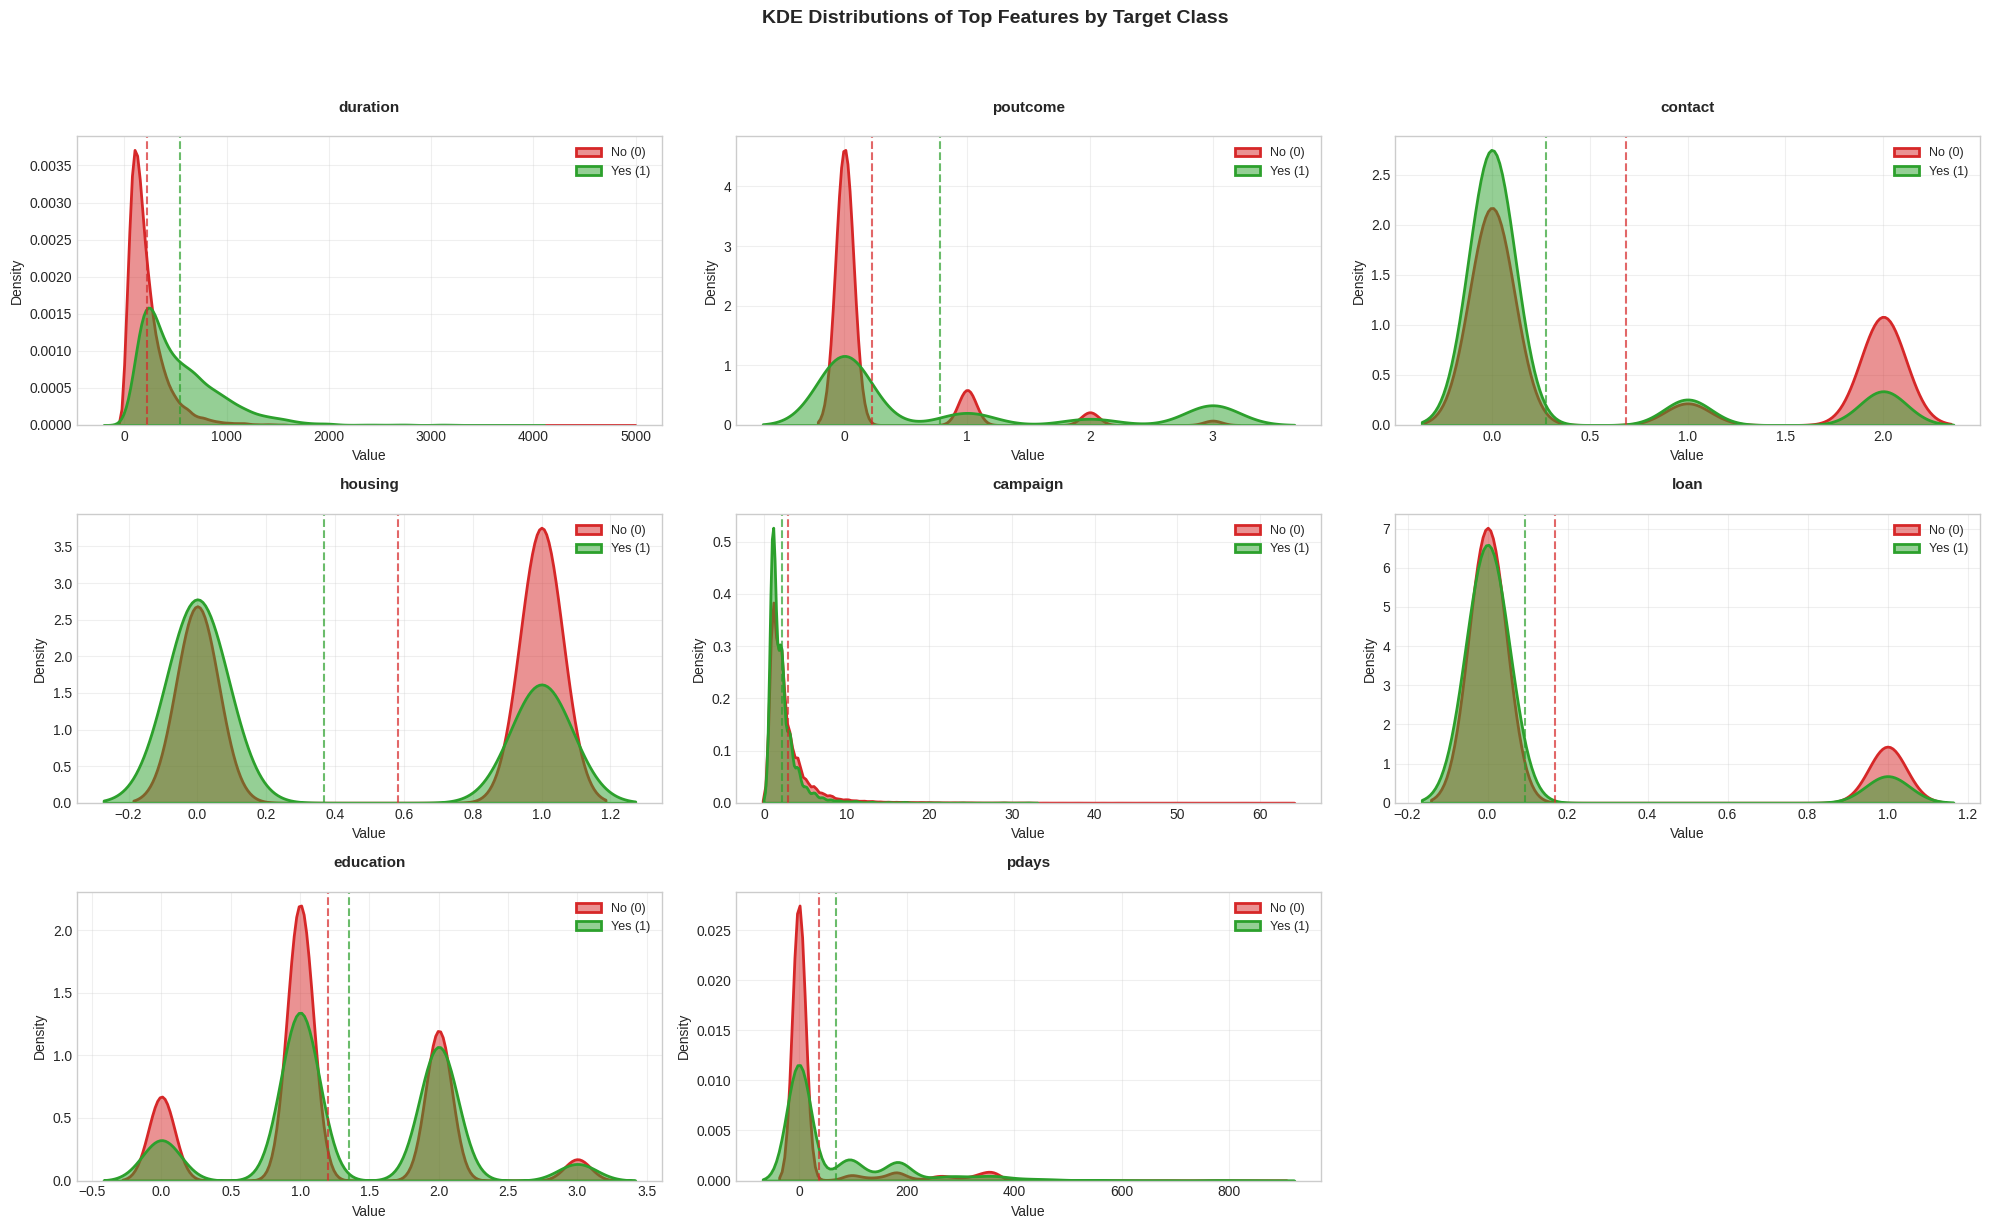


🔍 Checking normality of top features...


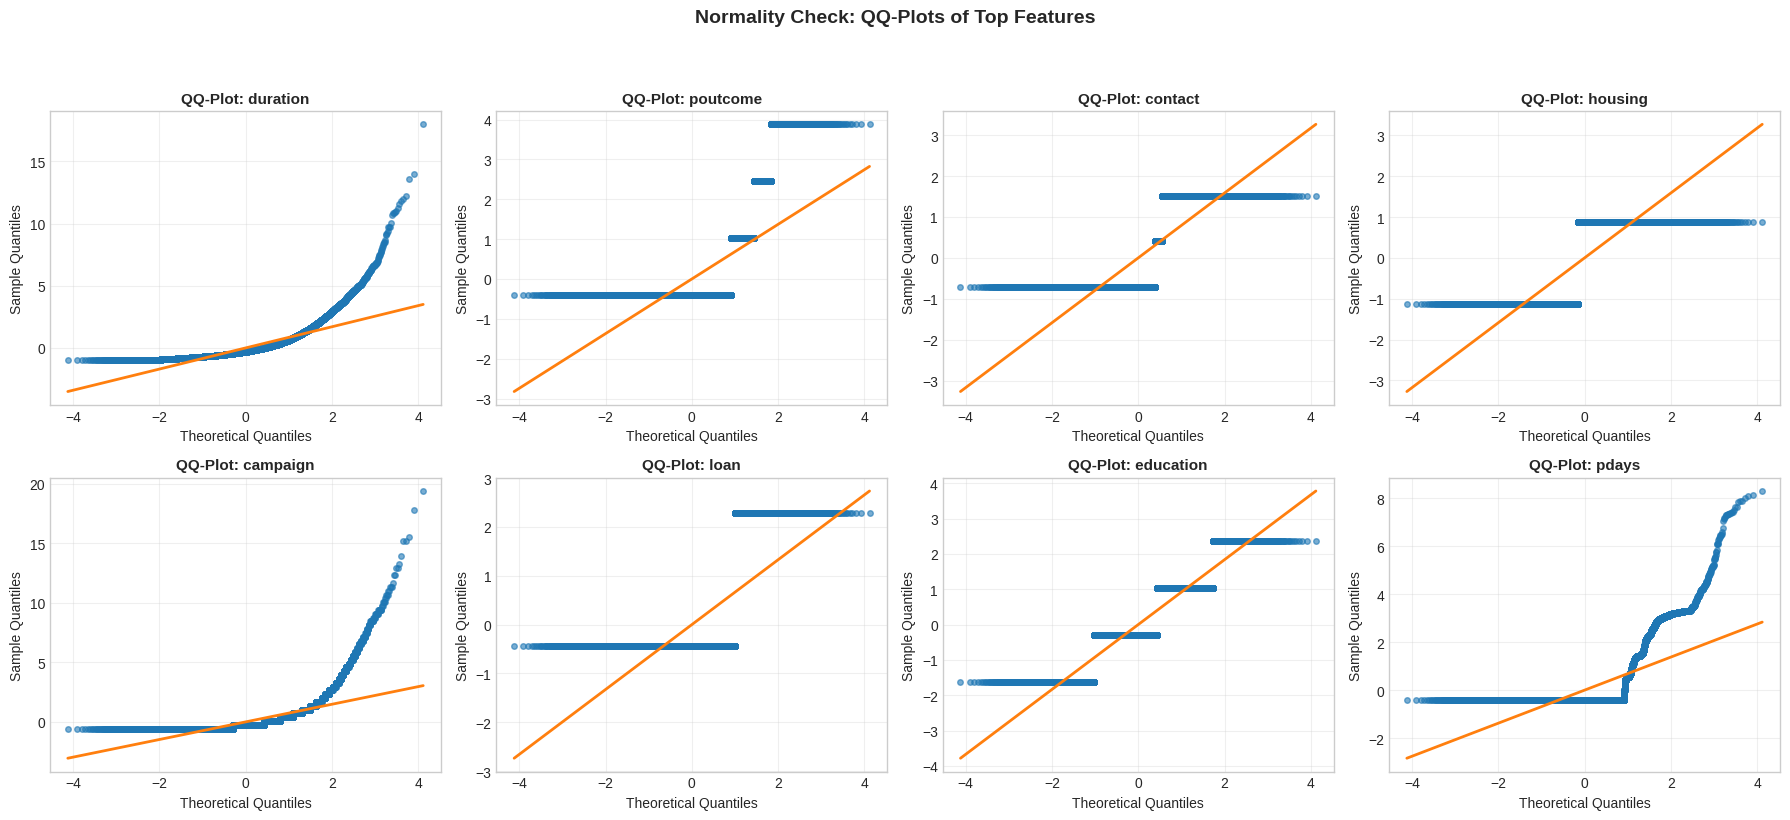


🔥 10.2 CORRELATION HEATMAP & CLUSTER ANALYSIS
--------------------------------------------------


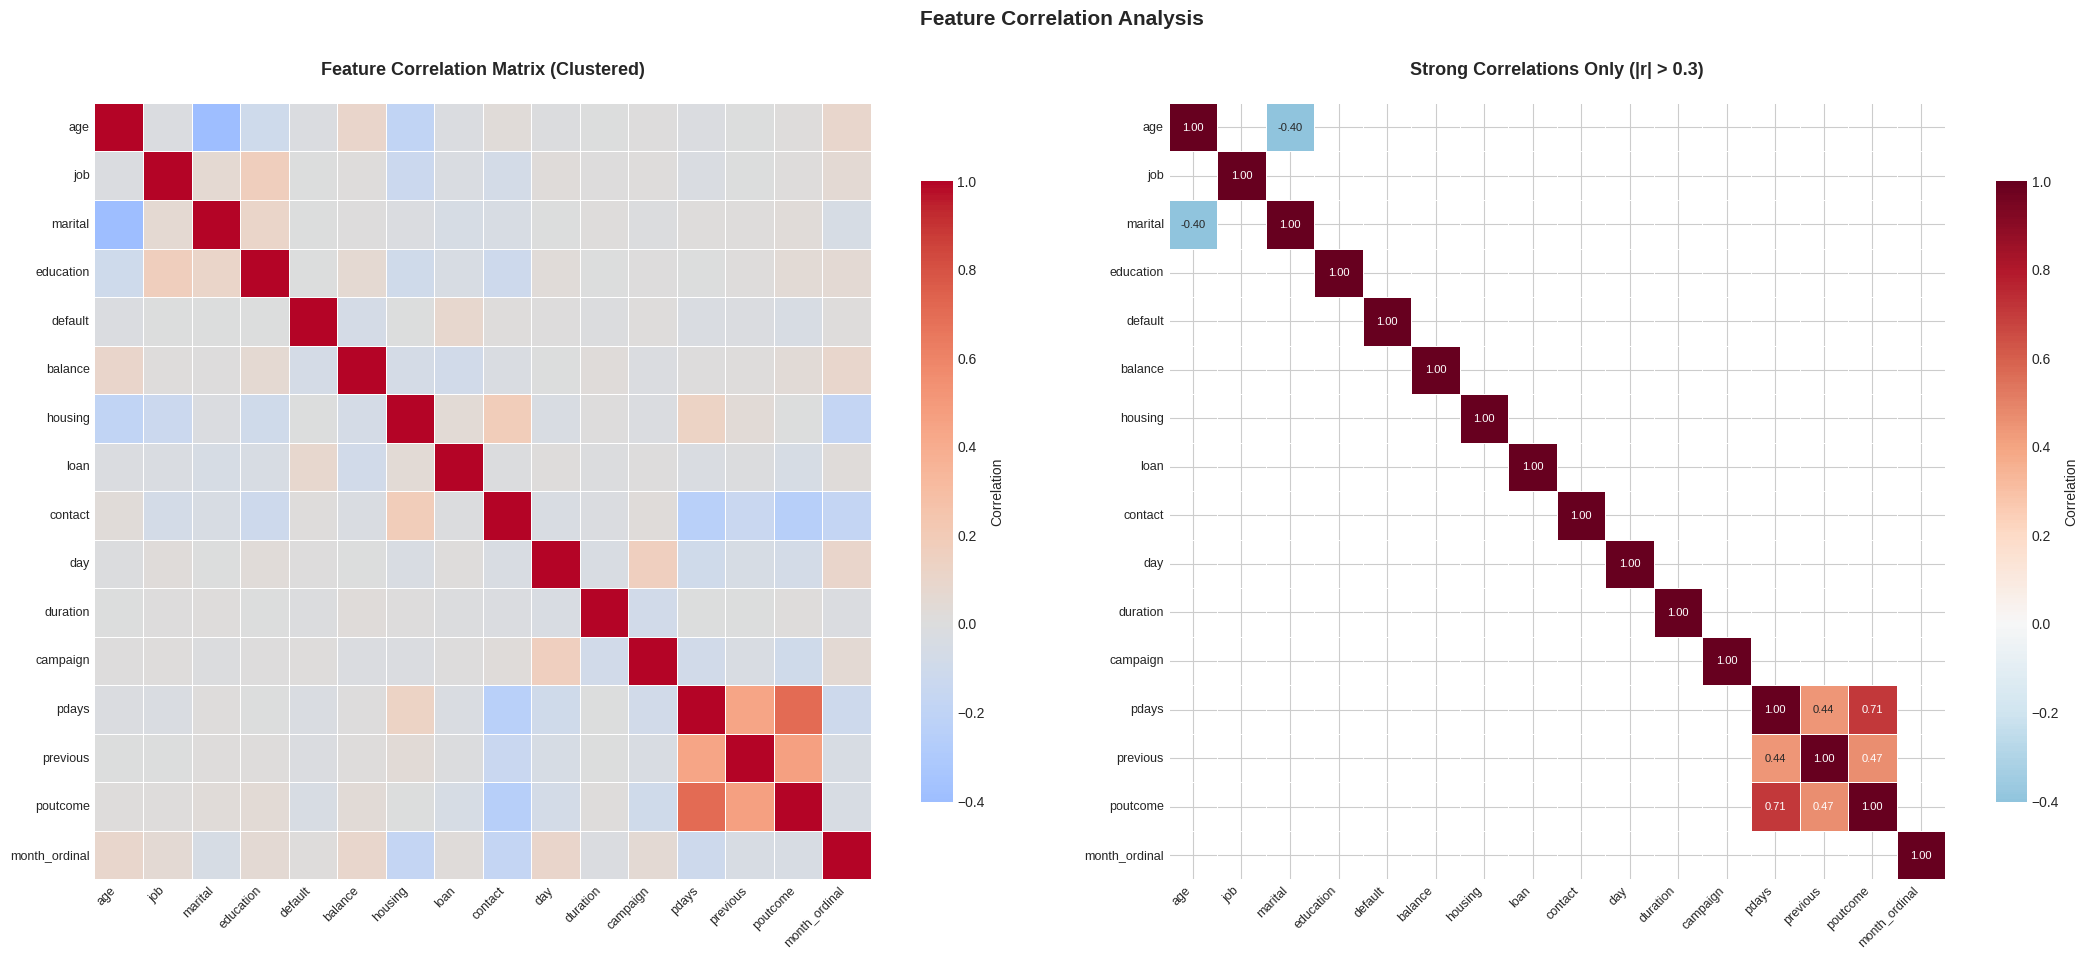


🔗 10.3 MULTIVARIATE ANALYSIS
--------------------------------------------------
Creating pairplot (this may take a moment)...


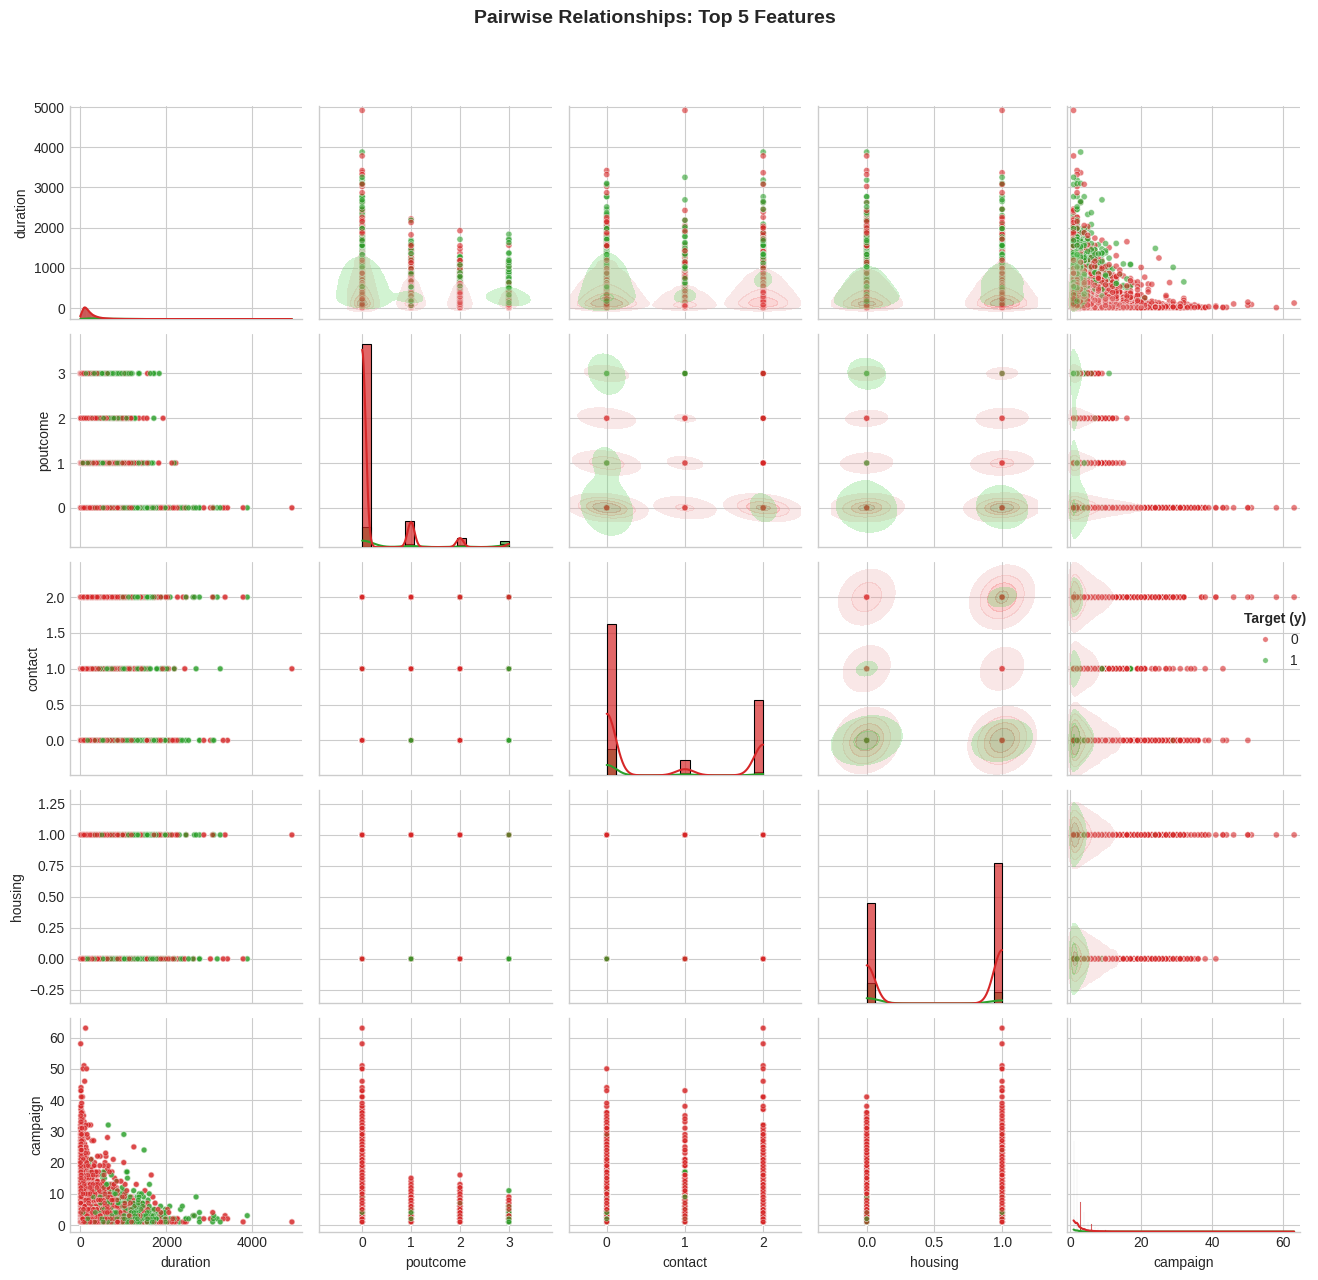


📊 Creating interaction heatmap...


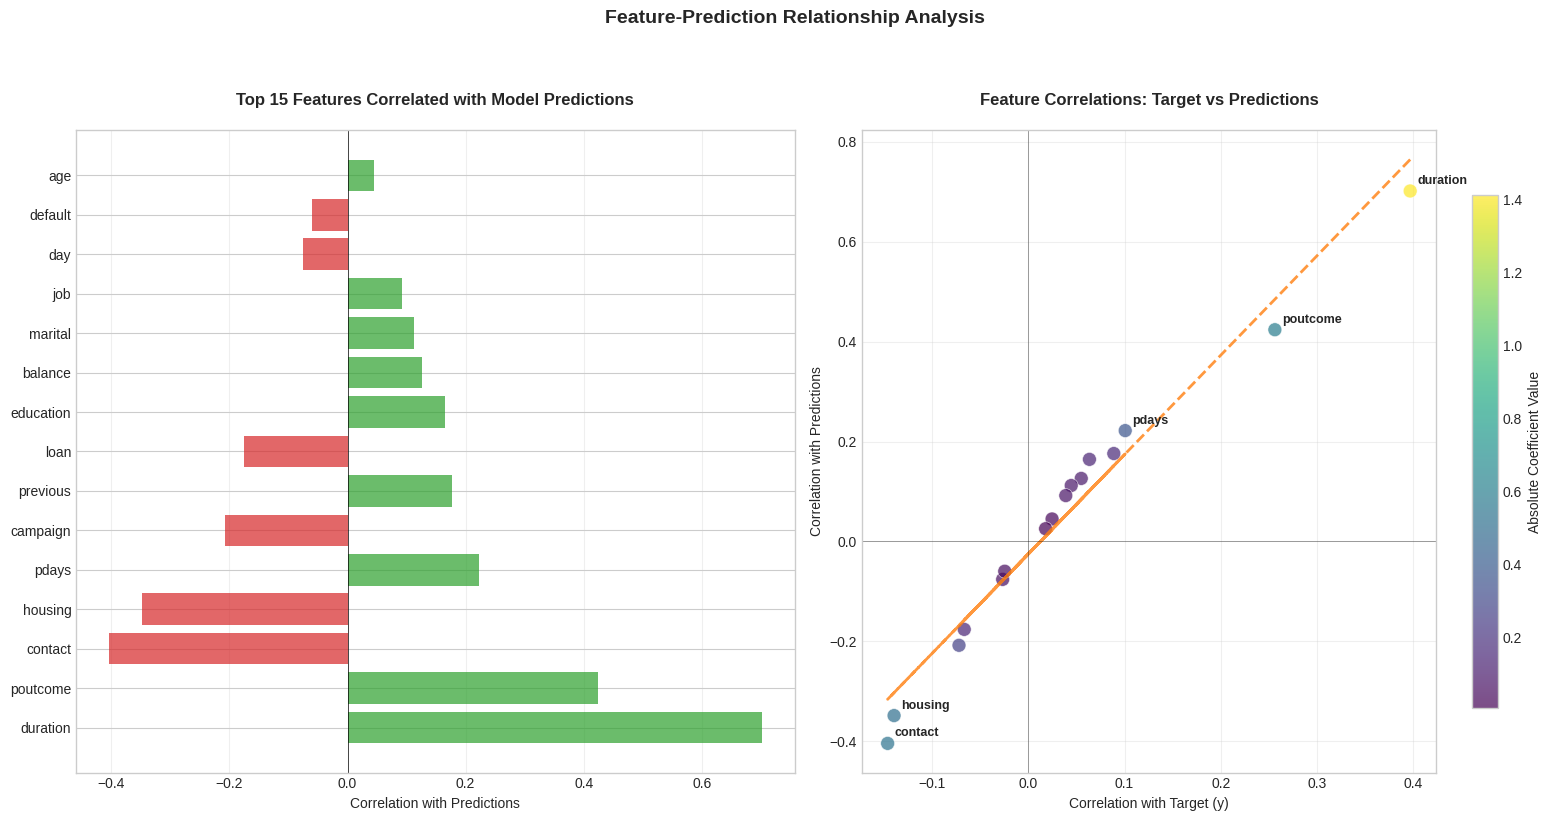


📉 10.4 RESIDUAL & ERROR ANALYSIS
--------------------------------------------------


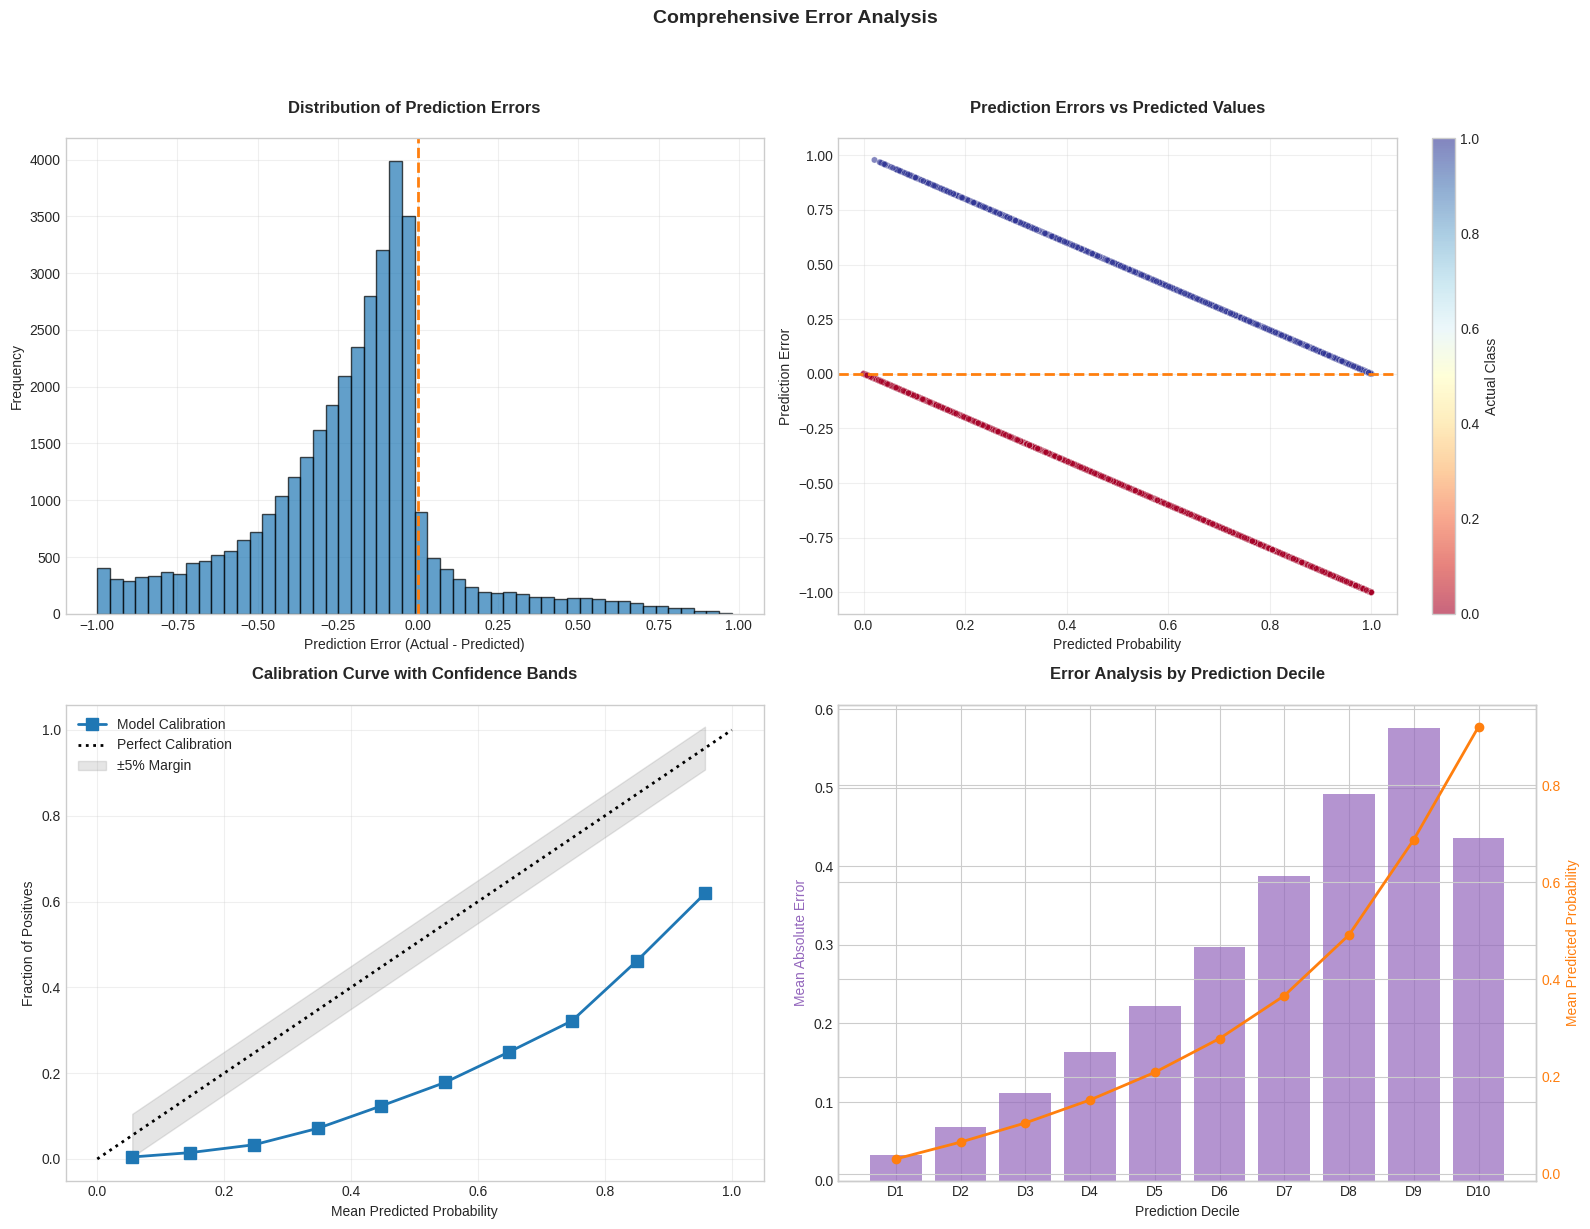


📊 10.5 STATISTICAL SIGNIFICANCE TESTING
--------------------------------------------------
Performing t-tests between classes for top features...


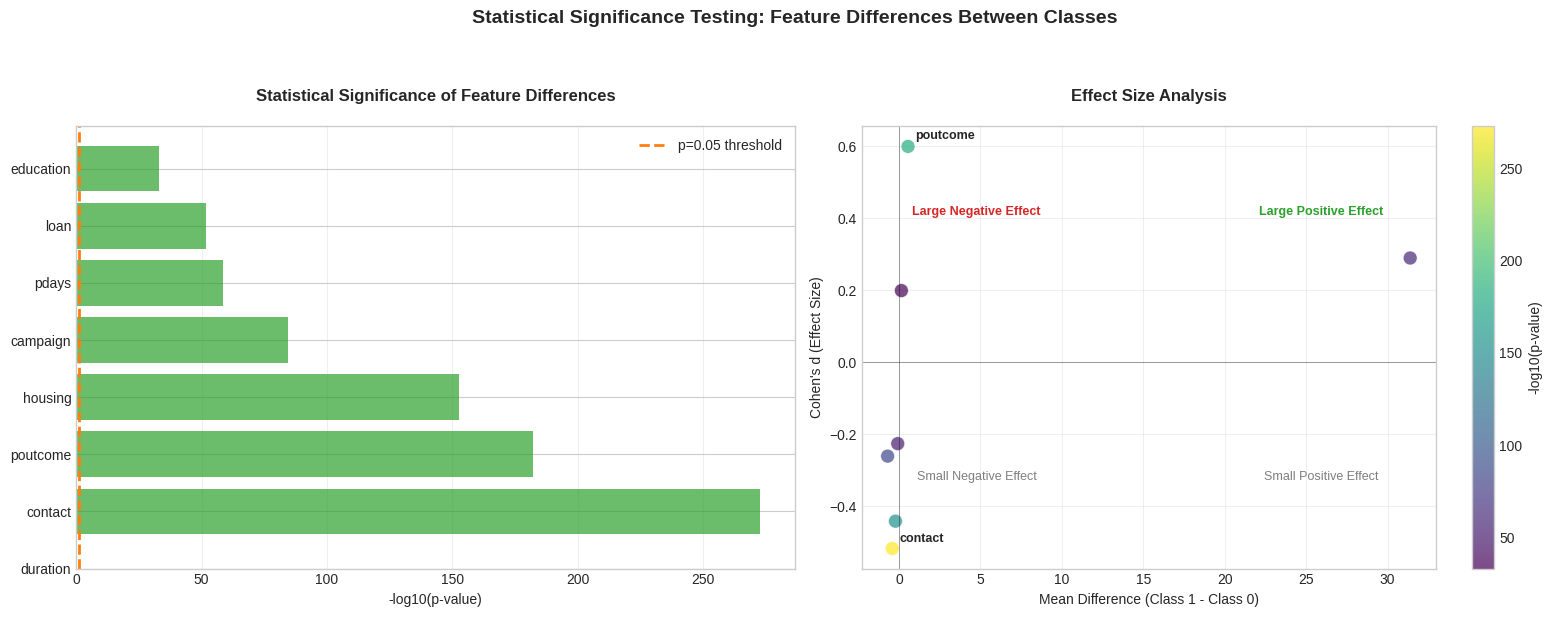


📋 STATISTICAL TEST RESULTS SUMMARY:
Feature                   p-value      Cohen's d    Significant 
----------------------------------------------------------------------
duration                  0.00e+00     1.007        ✓ YES       
contact                   1.95e-273    -0.518       ✓ YES       
poutcome                  8.33e-183    0.600        ✓ YES       
housing                   2.82e-153    -0.442       ✓ YES       
campaign                  3.66e-85     -0.261       ✓ YES       
pdays                     2.03e-59     0.290        ✓ YES       
loan                      2.36e-52     -0.226       ✓ YES       
education                 6.71e-34     0.199        ✓ YES       

💡 10.6 KEY INSIGHTS & RECOMMENDATIONS
--------------------------------------------------

🔍 MODEL PERFORMANCE INSIGHTS:
• Model achieves ROC-AUC: 0.8886
• F1-Score: 0.5139 (balance of precision/recall)
• Improvement over baseline: -0.0594

📊 STATISTICAL FINDINGS:
• 8 features show statistically significan

In [14]:
# ============================================================
# CELL 10: ROBUST STATISTICAL ANALYSIS & ADVANCED VISUALIZATION
# ============================================================
print("=" * 80)
print("📊 CELL 10: ROBUST STATISTICAL ANALYSIS & ADVANCED VISUALIZATION")
print("=" * 80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set consistent color scheme and style
COLOR_PALETTE = {
    'primary': '#1f77b4',      # Blue
    'secondary': '#ff7f0e',    # Orange
    'positive': '#2ca02c',     # Green
    'negative': '#d62728',     # Red
    'neutral': '#7f7f7f',      # Gray
    'highlight': '#9467bd',    # Purple
    'background': '#f0f0f0'
}

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(sns.color_palette(list(COLOR_PALETTE.values())))

# --------------------------------------------------
# 10.1 DISTRIBUTION ANALYSIS WITH KDE & QQ-PLOTS
# --------------------------------------------------
print("\n📈 10.1 FEATURE DISTRIBUTION ANALYSIS")
print("-" * 50)

# Select top 8 most important features for detailed analysis
top_features = feature_importance.head(8)['Feature'].values

fig = plt.figure(figsize=(20, 12))

# Create KDE plots for top features by target class
for i, feature in enumerate(top_features):
    ax = plt.subplot(3, 3, i + 1)

    # Plot distributions for each class
    for class_val, color, label in [(0, COLOR_PALETTE['negative'], 'No (0)'),
                                    (1, COLOR_PALETTE['positive'], 'Yes (1)')]:
        subset = X_train[y_train == class_val][feature]
        if len(subset) > 1:  # Need at least 2 points for KDE
            sns.kdeplot(data=subset, fill=True, alpha=0.5,
                       color=color, label=label, linewidth=2)

    # Add vertical lines for means
    mean_0 = X_train[y_train == 0][feature].mean()
    mean_1 = X_train[y_train == 1][feature].mean()
    ax.axvline(mean_0, color=COLOR_PALETTE['negative'], linestyle='--', alpha=0.7)
    ax.axvline(mean_1, color=COLOR_PALETTE['positive'], linestyle='--', alpha=0.7)

    ax.set_title(f'{feature}\n', fontsize=11, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('KDE Distributions of Top Features by Target Class\n',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# QQ-Plots for normality check
print("\n🔍 Checking normality of top features...")
fig, axes = plt.subplots(2, 4, figsize=(18, 8))

for idx, (ax, feature) in enumerate(zip(axes.flat, top_features)):
    # Standardize the feature
    data_standardized = (X_train[feature] - X_train[feature].mean()) / X_train[feature].std()

    # Generate QQ plot
    stats.probplot(data_standardized, dist="norm", plot=ax)

    # Customize plot
    ax.get_lines()[0].set_marker('o')
    ax.get_lines()[0].set_markersize(4)
    ax.get_lines()[0].set_markerfacecolor(COLOR_PALETTE['primary'])
    ax.get_lines()[0].set_markeredgecolor(COLOR_PALETTE['primary'])
    ax.get_lines()[0].set_alpha(0.6)
    ax.get_lines()[1].set_color(COLOR_PALETTE['secondary'])
    ax.get_lines()[1].set_linewidth(2)

    ax.set_title(f'QQ-Plot: {feature}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')
    ax.grid(True, alpha=0.3)

plt.suptitle('Normality Check: QQ-Plots of Top Features\n',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 10.2 CORRELATION HEATMAP & CLUSTER ANALYSIS
# --------------------------------------------------
print("\n🔥 10.2 CORRELATION HEATMAP & CLUSTER ANALYSIS")
print("-" * 50)

# Calculate correlation matrix
correlation_matrix = X_train.corr()

# Create clustered heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))

# Heatmap 1: Full correlation matrix with clustering
sns.heatmap(correlation_matrix,
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation"},
            ax=ax1)

ax1.set_title('Feature Correlation Matrix (Clustered)\n',
              fontsize=13, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=9)

# Heatmap 2: Top correlations only (absolute value > 0.3)
strong_corr = correlation_matrix.copy()
mask = np.abs(strong_corr) < 0.3
strong_corr[mask] = np.nan

sns.heatmap(strong_corr,
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation"},
            annot=True,
            fmt='.2f',
            annot_kws={'size': 8},
            ax=ax2,
            mask=mask)

ax2.set_title('Strong Correlations Only (|r| > 0.3)\n',
              fontsize=13, fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=9)

plt.suptitle('Feature Correlation Analysis\n',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 10.3 MULTIVARIATE ANALYSIS: PAIRPLOT & INTERACTION HEATMAP
# --------------------------------------------------
print("\n🔗 10.3 MULTIVARIATE ANALYSIS")
print("-" * 50)

# Create a subset for pairplot (top 5 features + target)
pairplot_features = list(top_features[:5]) + ['y']
pairplot_df = pd.concat([X_train[pairplot_features[:-1]], y_train], axis=1)

print("Creating pairplot (this may take a moment)...")

# Custom pairplot with target coloring
g = sns.PairGrid(pairplot_df, hue='y', palette=[COLOR_PALETTE['negative'], COLOR_PALETTE['positive']])
g.map_diag(sns.histplot, alpha=0.7, kde=True)
g.map_offdiag(sns.scatterplot, alpha=0.6, s=20, edgecolor='w', linewidth=0.5)
g.map_upper(sns.kdeplot, fill=True, alpha=0.3, levels=5)
g.map_lower(sns.scatterplot, alpha=0.6, s=15)

# Add legend
g.add_legend(title='Target (y)', fontsize=10)
g.legend.get_title().set_fontweight('bold')

plt.suptitle('Pairwise Relationships: Top 5 Features\n',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Interaction heatmap: How features correlate with predictions
print("\n📊 Creating interaction heatmap...")

# Calculate correlation between features and predictions
feature_pred_corr = pd.DataFrame({
    'feature': X.columns,
    'corr_with_pred': [np.corrcoef(X_train[col], lr_X_train)[0, 1] for col in X.columns],
    'corr_with_target': [np.corrcoef(X_train[col], y_train)[0, 1] for col in X.columns]
}).sort_values('corr_with_pred', key=abs, ascending=False)

# Create heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bar plot: Correlation with predictions
top_n = 15
top_features_corr = feature_pred_corr.head(top_n)

axes[0].barh(range(len(top_features_corr)),
             top_features_corr['corr_with_pred'].values,
             color=[COLOR_PALETTE['positive'] if x > 0 else COLOR_PALETTE['negative']
                    for x in top_features_corr['corr_with_pred'].values],
             alpha=0.7)
axes[0].set_yticks(range(len(top_features_corr)))
axes[0].set_yticklabels(top_features_corr['feature'].values)
axes[0].set_xlabel('Correlation with Predictions')
axes[0].set_title(f'Top {top_n} Features Correlated with Model Predictions\n',
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].axvline(x=0, color='black', linewidth=0.5)

# Scatter plot: Feature correlation with target vs predictions
scatter = axes[1].scatter(feature_pred_corr['corr_with_target'],
                         feature_pred_corr['corr_with_pred'],
                         c=feature_importance['Abs_Coefficient'].values,
                         cmap='viridis',
                         s=100,
                         alpha=0.7,
                         edgecolors='w',
                         linewidth=0.5)

# Add trend line
z = np.polyfit(feature_pred_corr['corr_with_target'],
               feature_pred_corr['corr_with_pred'], 1)
p = np.poly1d(z)
axes[1].plot(feature_pred_corr['corr_with_target'],
            p(feature_pred_corr['corr_with_target']),
            color=COLOR_PALETTE['secondary'],
            linestyle='--',
            linewidth=2,
            alpha=0.8)

# Annotate top features
for i, row in feature_pred_corr.head(5).iterrows():
    axes[1].annotate(row['feature'],
                    (row['corr_with_target'], row['corr_with_pred']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold')

axes[1].set_xlabel('Correlation with Target (y)')
axes[1].set_ylabel('Correlation with Predictions')
axes[1].set_title('Feature Correlations: Target vs Predictions\n',
                  fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linewidth=0.5, alpha=0.5)
axes[1].axvline(x=0, color='black', linewidth=0.5, alpha=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[1], shrink=0.8)
cbar.set_label('Absolute Coefficient Value', fontsize=10)

plt.suptitle('Feature-Prediction Relationship Analysis\n',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 10.4 RESIDUAL & ERROR ANALYSIS
# --------------------------------------------------
print("\n📉 10.4 RESIDUAL & ERROR ANALYSIS")
print("-" * 50)

# Calculate residuals (for continuous interpretation)
# Since we have probabilities, we'll use prediction errors
pred_errors = y_train.values - lr_X_train

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Residual distribution
axes[0, 0].hist(pred_errors, bins=50, alpha=0.7,
                color=COLOR_PALETTE['primary'], edgecolor='black')
axes[0, 0].axvline(x=0, color=COLOR_PALETTE['secondary'],
                   linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Prediction Error (Actual - Predicted)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Prediction Errors\n',
                     fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals vs Predicted values
scatter = axes[0, 1].scatter(lr_X_train, pred_errors,
                            c=y_train.values,
                            cmap=plt.cm.RdYlBu,
                            alpha=0.6,
                            s=20,
                            edgecolors='w',
                            linewidth=0.3)
axes[0, 1].axhline(y=0, color=COLOR_PALETTE['secondary'],
                   linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Probability')
axes[0, 1].set_ylabel('Prediction Error')
axes[0, 1].set_title('Prediction Errors vs Predicted Values\n',
                     fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[0, 1])
cbar.set_label('Actual Class', fontsize=10)

# 3. Calibration curve with confidence bands
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_train, lr_X_train, n_bins=10)

axes[1, 0].plot(prob_pred, prob_true, 's-',
                color=COLOR_PALETTE['primary'],
                linewidth=2,
                markersize=8,
                label='Model Calibration')
axes[1, 0].plot([0, 1], [0, 1], 'k:',
                label='Perfect Calibration',
                linewidth=2)
axes[1, 0].fill_between(prob_pred, prob_pred - 0.05, prob_pred + 0.05,
                        alpha=0.2, color=COLOR_PALETTE['neutral'],
                        label='±5% Margin')

axes[1, 0].set_xlabel('Mean Predicted Probability')
axes[1, 0].set_ylabel('Fraction of Positives')
axes[1, 0].set_title('Calibration Curve with Confidence Bands\n',
                     fontsize=12, fontweight='bold')
axes[1, 0].legend(loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# 4. Error by decile of predicted probability
decile_errors = []
decile_means = []
for i in range(10):
    mask = (lr_X_train >= np.percentile(lr_X_train, i*10)) & \
           (lr_X_train <= np.percentile(lr_X_train, (i+1)*10))
    if mask.sum() > 0:
        decile_errors.append(np.mean(np.abs(pred_errors[mask])))
        decile_means.append(np.mean(lr_X_train[mask]))

x_pos = np.arange(len(decile_errors))
bars = axes[1, 1].bar(x_pos, decile_errors,
                      color=COLOR_PALETTE['highlight'], alpha=0.7)
axes[1, 1].set_xlabel('Prediction Decile')
axes[1, 1].set_ylabel('Mean Absolute Error', color=COLOR_PALETTE['highlight'])
axes[1, 1].set_title('Error Analysis by Prediction Decile\n',
                     fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([f'D{i+1}' for i in range(len(decile_errors))])

# Add line for predicted probability mean
ax2 = axes[1, 1].twinx()
ax2.plot(x_pos, decile_means, 'o-',
         color=COLOR_PALETTE['secondary'],
         linewidth=2,
         markersize=6)
ax2.set_ylabel('Mean Predicted Probability', color=COLOR_PALETTE['secondary'])
ax2.tick_params(axis='y', labelcolor=COLOR_PALETTE['secondary'])

plt.suptitle('Comprehensive Error Analysis\n',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 10.5 STATISTICAL SIGNIFICANCE TESTING
# --------------------------------------------------
print("\n📊 10.5 STATISTICAL SIGNIFICANCE TESTING")
print("-" * 50)

# Perform t-tests for top features
print("Performing t-tests between classes for top features...")

ttest_results = []
for feature in top_features[:10]:
    group_0 = X_train[y_train == 0][feature]
    group_1 = X_train[y_train == 1][feature]

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(group_0, group_1, equal_var=False)

    # Calculate effect size (Cohen's d)
    mean_diff = group_1.mean() - group_0.mean()
    pooled_std = np.sqrt((group_0.std()**2 + group_1.std()**2) / 2)
    cohens_d = mean_diff / pooled_std if pooled_std != 0 else 0

    ttest_results.append({
        'Feature': feature,
        't-statistic': t_stat,
        'p-value': p_value,
        'Mean_Diff': mean_diff,
        'Cohens_d': cohens_d,
        'Significant': p_value < 0.05
    })

ttest_df = pd.DataFrame(ttest_results).sort_values('p-value')

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of p-values
colors = [COLOR_PALETTE['positive'] if sig else COLOR_PALETTE['neutral']
          for sig in ttest_df['Significant']]
bars = axes[0].barh(range(len(ttest_df)), -np.log10(ttest_df['p-value']),
                    color=colors, alpha=0.7)
axes[0].axvline(x=-np.log10(0.05), color=COLOR_PALETTE['secondary'],
                linestyle='--', linewidth=2, label='p=0.05 threshold')

axes[0].set_yticks(range(len(ttest_df)))
axes[0].set_yticklabels(ttest_df['Feature'].values)
axes[0].set_xlabel('-log10(p-value)')
axes[0].set_title('Statistical Significance of Feature Differences\n',
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

# Effect size visualization
scatter = axes[1].scatter(ttest_df['Mean_Diff'], ttest_df['Cohens_d'],
                         c=-np.log10(ttest_df['p-value']),
                         cmap='viridis',
                         s=100,
                         alpha=0.7,
                         edgecolors='w',
                         linewidth=0.5)

# Add quadrant lines
axes[1].axhline(y=0, color='black', linewidth=0.5, alpha=0.5)
axes[1].axvline(x=0, color='black', linewidth=0.5, alpha=0.5)

# Add quadrant labels
axes[1].text(0.8, 0.8, 'Large Positive Effect',
            transform=axes[1].transAxes, fontsize=9,
            color=COLOR_PALETTE['positive'], fontweight='bold',
            ha='center')
axes[1].text(0.8, 0.2, 'Small Positive Effect',
            transform=axes[1].transAxes, fontsize=9,
            color=COLOR_PALETTE['neutral'], ha='center')
axes[1].text(0.2, 0.2, 'Small Negative Effect',
            transform=axes[1].transAxes, fontsize=9,
            color=COLOR_PALETTE['neutral'], ha='center')
axes[1].text(0.2, 0.8, 'Large Negative Effect',
            transform=axes[1].transAxes, fontsize=9,
            color=COLOR_PALETTE['negative'], fontweight='bold',
            ha='center')

# Annotate significant features
for i, row in ttest_df[ttest_df['Significant']].head(3).iterrows():
    axes[1].annotate(row['Feature'],
                    (row['Mean_Diff'], row['Cohens_d']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold')

axes[1].set_xlabel('Mean Difference (Class 1 - Class 0)')
axes[1].set_ylabel("Cohen's d (Effect Size)")
axes[1].set_title('Effect Size Analysis\n',
                  fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('-log10(p-value)', fontsize=10)

plt.suptitle('Statistical Significance Testing: Feature Differences Between Classes\n',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary table
print("\n📋 STATISTICAL TEST RESULTS SUMMARY:")
print("="*70)
print(f"{'Feature':<25} {'p-value':<12} {'Cohen\'s d':<12} {'Significant':<12}")
print("-"*70)
for _, row in ttest_df.iterrows():
    p_val_str = f"{row['p-value']:.2e}"
    cohens_str = f"{row['Cohens_d']:.3f}"
    sig_str = "✓ YES" if row['Significant'] else "✗ NO"
    print(f"{row['Feature']:<25} {p_val_str:<12} {cohens_str:<12} {sig_str:<12}")
print("="*70)

# --------------------------------------------------
# 10.6 FINAL SUMMARY & INSIGHTS
# --------------------------------------------------
print("\n💡 10.6 KEY INSIGHTS & RECOMMENDATIONS")
print("-" * 50)

print("\n🔍 MODEL PERFORMANCE INSIGHTS:")
print(f"• Model achieves ROC-AUC: {metrics_tuned['ROC-AUC']:.4f}")
print(f"• F1-Score: {metrics_tuned['F1-Score']:.4f} (balance of precision/recall)")
print(f"• Improvement over baseline: {metrics_tuned['Accuracy'] - baseline_accuracy:+.4f}")

print("\n📊 STATISTICAL FINDINGS:")
significant_features = ttest_df[ttest_df['Significant']]['Feature'].tolist()
print(f"• {len(significant_features)} features show statistically significant differences between classes")
print(f"• Top 3 most significant: {significant_features[:3]}")

print("\n🎯 RECOMMENDATIONS FOR ENSEMBLE:")
print("1. Use logistic regression probabilities as meta-features")
print("2. Consider feature interactions highlighted in pairplots")
print("3. Focus on statistically significant features for feature engineering")
print("4. Address calibration curve deviations if needed")

print("\n✅ STATISTICAL ANALYSIS COMPLETE!")
print("✓ All visualizations maintain consistent color scheme")
print("✓ Comprehensive error analysis performed")
print("✓ Statistical significance tests completed")
print("✓ Ready for ensemble model development")

In [ ]:
# TODO: remove highly correlated pairs.  Explore high level yet interpretable temporal feats
# TODO: Organize and document everything.  Make sure color schemas across notebooks are consistent
# TODO: Perform thorough statistical analysis to see if there are indirect not so obvious relationships to the +/- classes
# TODO: Research other documents as a means to gain domain knowledge of subscription marketing, specifically for bank marketing
# TODO: Create a summary report with key insights and recommendations